# Convolution Deep Neural Networks
---
*Responsible:* Robert Currie (<rob.currie@ed.ac.uk>)

### Description:
This is a longer notebook than we have had previously. It is intended as a hands-on example to using CNN/CDN models in different situations.

There are 4 sections:

**Image Filtering**- This section is intended to give you an idea how the Sobel Operator works.

**CNN training with cifar10** - This section is intended to give an example of training a CNN model to a dataset. This also shows you how to avoid problems due to a complex model and a limited dataset size.

**VAE examples with mnist** - This section is intended to give you an example of using a CNN VAE model to perform an un-supervised training over a dataset.

**Anomaly Detection** - This section shows how you can make use of the latent-space of these models to perform anomaly detection.

## Marking

As with last weeks notebook the sections marked **##FINISH ME##** need to be completed for the notebook to work.

Marks for the different parts are shown below.

* Sections are intended to be tackled in order, i.e. 1->9
* In this notebook different sections can be tackled independently
* There are bonus problems at the end to tackle but the maximum mark is 10/10

| <p align='left'> Title                         | <p align='left'> Parts | <p align='left'> Number of marks |
| ------------------------------------- | ----- | --- |
| <p align='left'> 1. Image Filtering (question)          | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 2. CNN training with cifar10 (code)     | <p align='left'>  1  | <p align='left'> 1 |
| <p align='left'> 2. CNN training with cifar10 (questions)| <p align='left'>  4  | <p align='left'> 4 |
| <p align='left'> 3. VAE examples with mnist (sections marked Q) | <p align='left'>  4  | <p align='left'> 4 |
| <p align='left'> 4. **Bonus:** Anomaly Detection            | <p align='left'>  3  | <p align='left'> 3 |
| <p align='left'> **Total** | | <p align='left'> max **10** |


# Setup our notebook env
---
Import all of the dependencies for our notebook.

In [37]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.activations import gelu
from tensorflow.keras import models, layers, datasets, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.datasets import fetch_olivetti_faces

# Image Filtering
---
We're now going to go through an example of applying an image filter operator on an input image.

In reality we normally tend to use libraries which accelerate this rather than doing these calculations in a higher level language such as Python.

In [38]:
image_file = 'image.png'
input_image = imread(image_file)  # this is the array representation of the input image

## Plot our Input
---
Lets have a look at our input image from wikipedia: https://en.wikipedia.org/wiki/File:Eilean_Donan_Castle,_Scotland_-_Jan_2011.jpg

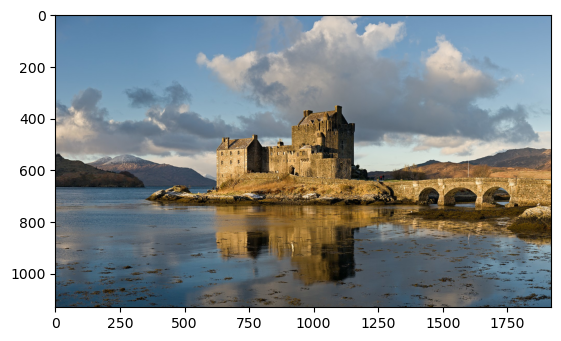

In [39]:
fig1 = plt.figure(1)
pic1=fig1.add_subplot()
pic1.imshow(input_image, cmap=plt.get_cmap('gray'))
fig1.show()

### Convert to grayscale
---
This short section of code downsamples our input image to greyscale

In [40]:
# Extracting each one of the RGB components
r_img, g_img, b_img = input_image[:, :, 0], input_image[:, :, 1], input_image[:, :, 2]
# The following operation will take weights and parameters to convert the color image to grayscale
gamma = 1.400  # a parameter
r_const, g_const, b_const = 0.2126, 0.7152, 0.0722  # weights for the RGB components respectively
grayscale_image = r_const * r_img ** gamma + g_const * g_img ** gamma + b_const * b_img ** gamma

## Build our sobel operators

Build our Sobel operators

```
The kernels Gx and Gy as covered in the last lecture:
      _               _                   _                _
     |                 |                 |                  |
     | 1.0   0.0  -1.0 |                 |  1.0   2.0   1.0 |
Gx = | 2.0   0.0  -2.0 |    and     Gy = |  0.0   0.0   0.0 |
     | 1.0   0.0  -1.0 |                 | -1.0  -2.0  -1.0 |
     |_               _|                 |_                _|
```

In [41]:
# Here we define the matrices associated with the Sobel filter
Gx = np.array([
     1.0,  0.0,  -1.0,
     2.0,  0.0,  -2.0,
     1.0,  0.0,  -1.0,
])

Gy = np.array([
      1.0,  2.0,  1.0,
      0.0,  0.0,  0.0,
     -1.0, -2.0, -1.0,
])

[rows, columns] = np.shape(grayscale_image)  # we need to know the shape of the input grayscale image

sobel_filtered_image_x = np.zeros(shape=(rows, columns))  # initialization of the output image array (all elements are 0)
sobel_filtered_image_y = np.zeros(shape=(rows, columns))  # initialization of the output image array (all elements are 0)
sobel_filtered_image = np.zeros(shape=(rows, columns))  # initialization of the output image array (all elements are 0)

Now we apply the Operator to our input

A suitable example method for applying the full sobel operator to our input data is:
```
# Now we "sweep" the image in both x and y directions and compute the output
for i in range(rows - 2):
    for j in range(columns - 2):
        gx = np.sum(np.multiply(Gx, grayscale_image[i:i + 3, j:j + 3]))  # x direction
        gy = np.sum(np.multiply(Gy, grayscale_image[i:i + 3, j:j + 3]))  # y direction

        sobel_filtered_image[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2)  # calculate the "hypotenuse"
```

In [42]:
# Now we "sweep" the image in both x and y directions and compute the output
for i in range(rows - 2):
    for j in range(columns - 2):
        # print(Gx)
        # print(grayscale_image[i:i + 3, j:j + 3])
        gx = np.sum(np.multiply(Gx.reshape(3,3), grayscale_image[i:i + 3, j:j + 3]))  # x direction
        gy = np.sum(np.multiply(Gy.reshape(3,3), grayscale_image[i:i + 3, j:j + 3]))  # y direction

        sobel_filtered_image_x[i+1, j+1] = gx
        sobel_filtered_image_y[i+1, j+1] = gy
        sobel_filtered_image[i+1, j+1] = np.sqrt(gx**2 + gy**2)           # calculate the overall sobel filter

### Now Plot our output

Plot the output of applying G_x, G_y and G operators each on the input image.

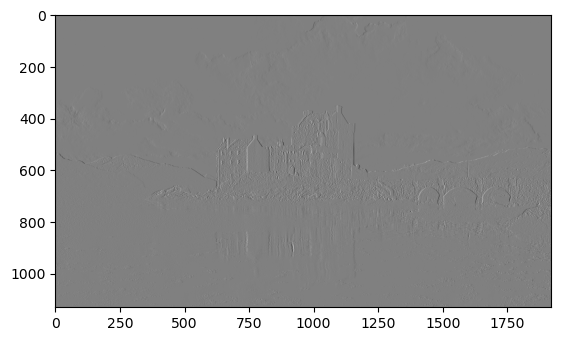

In [43]:
fig1 = plt.figure(1)
pic1=fig1.add_subplot()
pic1.imshow(sobel_filtered_image_x, cmap=plt.get_cmap('gray'))
fig1.show()

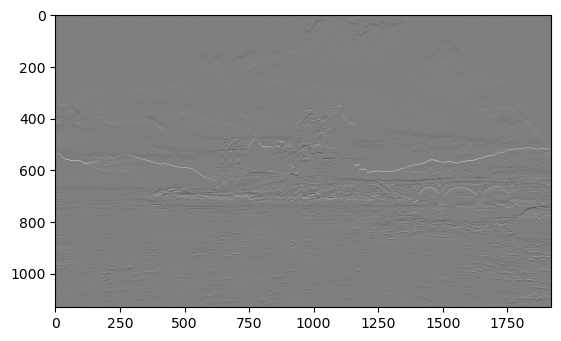

In [44]:
fig1 = plt.figure(1)
pic1=fig1.add_subplot()
pic1.imshow(sobel_filtered_image_y, cmap=plt.get_cmap('gray'))
fig1.show()

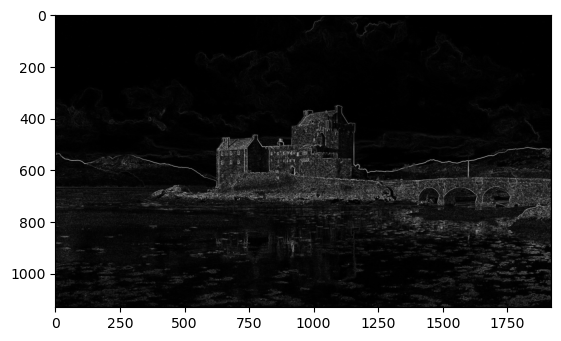

In [45]:
fig1 = plt.figure(1)
pic1=fig1.add_subplot()
pic1.imshow(sobel_filtered_image, cmap=plt.get_cmap('gray'))
fig1.show()

### Q: What is the difference between the G_x and G operator?

The sobel operator is used find the edges in images. This is typically done by discriminating aread of the image that have a large difference in pixel values between ajacent pixels (computing the $2^{nd}$ order derrivative of an image in a specific direction). 

The $G_x$ operator will discriminate edges in a horizontal direction, hence any large change between pixels ajacent to each other vertically will not be discriminated and taken into account. 

Meanwhile, the $G$ operator is the square root of the sum of squares of the $G_x$ and $G_y$ operators, hence the G operator combines the edges of an image in both the horizontal and vertical direction, resulting $G$ finding the edges of an image in all directions. This is a similar result to the application of the laplacian operator.

# CNN training with cifar10
---

This section gives an example of using a CNN to train on the cifar10 dataset.

The cifar10 dataset is a dataset of labelled images which is composed of the categories `['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']`.

As the dataset is composed of colour images, the data is composed of pixels in 3 dimensions, (r,g,b) which are used to construct a full colour image.

This dataset contains a lot of low-resolution images that have been hand labelled, however, this is a finite dataset with quite a few categories which means training to the dataset can be tricky. Typically a lot of simple CNN models tend to reach a non-overfitted accuracy of 70-80%.


Lets start by loading the dataset:

In [46]:
#load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#hyper-parameters
BATCH_SIZE = 600
nb_epochs = 15
VALIDATION_SPLIT = 0.2
num_classes = 10
minimum_pixel_value = X_train.min().astype("float32")
maximum_pixel_value = X_train.max().astype("float32")


# dataset 
num_train, img_channels, img_rows, img_cols = X_train.shape
num_test, _, _, _= X_test.shape
class_names =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Plot some examples from our input
---
Plot a single example from each of the classes in the dataset and label them

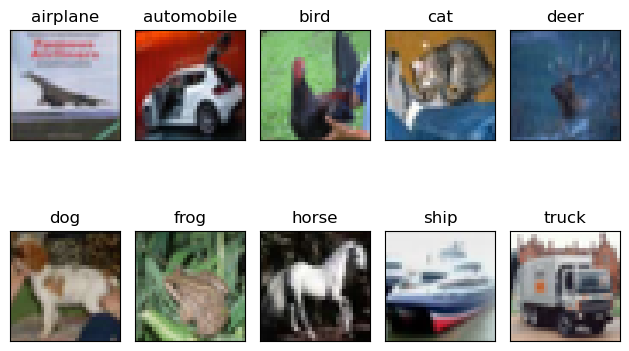

In [47]:
fig, ((ax0, ax1, ax2, ax3, ax4,),(ax5, ax6, ax7, ax8, ax9)) = plt.subplots(2, 5)

axes = (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9,)

for i in range(num_classes):
    image = X_test[np.argwhere(y_test==i)[0,0]]
    axes[i].imshow(image,)
    axes[i].set_title(class_names[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

### Now we're going to Normalize the dataset

In [48]:
# convert to categorical
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

#float and normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= maximum_pixel_value
X_test /= maximum_pixel_value

## Build CNN model
---

Build a CNN model using the Sequential API which has:
```
1. InputLayer
2. Conv2D x 32 with kernel 3x3 and strides=2
3. ReLU
4. Conv2D x 128 with kernel 3x3 and strides=1
5. ReLU
6. Flatten
7. Dense x 1024
8. ReLU
9. Dense x 1024
10. ReLU
11. Dense x classes
12. softmax
```

This model will be used multiple times so we want to wrap it in a function.

In [49]:
def create_cnn_model():
    model = Sequential()
    model.add( InputLayer(input_shape=X_train.shape[1:]) )
    model.add( Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same') )
    model.add( Activation('relu') )
    model.add( Conv2D(filters=128, kernel_size=3, strides=1, padding="same") )
    model.add( Activation('relu') )
    model.add( Flatten() )
    model.add( Dense(1024,))# use_bias=True, kernel_initializer="RandomUniform") )
    model.add( Activation('relu') )
    model.add( Dense(1024,))# use_bias=True, kernel_initializer="RandomUniform") )
    model.add( Activation('relu') )
    model.add( Dense(num_classes) )
    model.add( Activation('softmax') )
    return model

In [50]:
model = create_cnn_model()
model.compile(loss= 'categorical_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 activation_11 (Activation)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       36992     
                                                                 
 activation_12 (Activation)  (None, 16, 16, 128)       0         
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)              33555456  
                                                                 
 activation_13 (Activation)  (None, 1024)             

### Training our model
---

As per training a DNN to the mnist dataset we want to train our CDN to our cifar10 dataset.

In [51]:
model_history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = nb_epochs, validation_data = (X_test, y_test), verbose=1)

Epoch 1/15
84/84 [==============================] - 22s 257ms/step - loss: 1.7091 - accuracy: 0.3851 - val_loss: 1.3715 - val_accuracy: 0.4987
Epoch 2/15
84/84 [==============================] - 22s 257ms/step - loss: 1.1794 - accuracy: 0.5786 - val_loss: 1.1063 - val_accuracy: 0.6092
Epoch 3/15
84/84 [==============================] - 21s 255ms/step - loss: 0.9728 - accuracy: 0.6517 - val_loss: 1.0149 - val_accuracy: 0.6437
Epoch 4/15
84/84 [==============================] - 22s 257ms/step - loss: 0.7662 - accuracy: 0.7315 - val_loss: 0.9666 - val_accuracy: 0.6612
Epoch 5/15
84/84 [==============================] - 22s 257ms/step - loss: 0.5614 - accuracy: 0.8065 - val_loss: 0.9966 - val_accuracy: 0.6713
Epoch 6/15
84/84 [==============================] - 22s 257ms/step - loss: 0.3727 - accuracy: 0.8747 - val_loss: 1.0997 - val_accuracy: 0.6596
Epoch 7/15
84/84 [==============================] - 21s 255ms/step - loss: 0.1926 - accuracy: 0.9410 - val_loss: 1.2693 - val_accuracy: 0.6710

### Now examine the loss functions from this fit
---

Plot the model losses for the training and validation datasets.

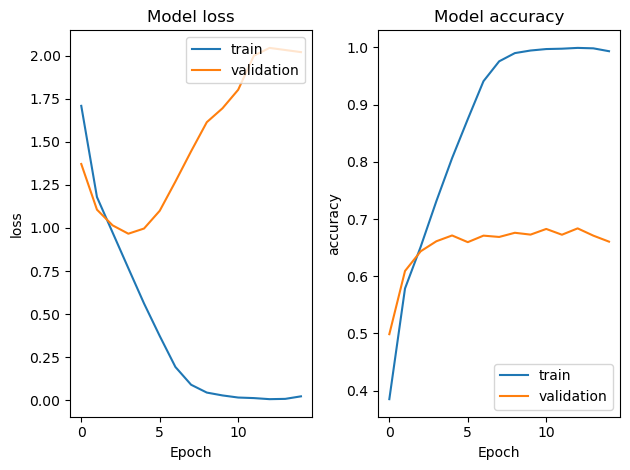

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(model_history.history['loss'])
ax1.plot(model_history.history['val_loss'])
ax1.set_title("Model loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend(['train','validation'], loc = 'upper right')


ax2.plot(model_history.history['accuracy'])
ax2.plot(model_history.history['val_accuracy'])
ax2.set_title("Model accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train','validation'], loc = 'lower right')

plt.tight_layout()
plt.show()

### Q: Has the model converged to a good description of the dataset? If not why not?

No. From the above loss plot, while the training loss of the model converges to what seems like an accurate description of the dataset; the validation loss is diverging from the training loss and the validation acuracy stagnates significantly different value than the training acuracy.

This is a clear indication that the model has been overtrained and is no longer capable of being generalied to data samples outside of the training dataset.

This is most likely a result of the training dataset being too small, which may be improved by using an image generator to slightly modify training dataset to inclrease the overall number of images used to train the model.

## Setup an Image Generator
---
In order to try and mitigate problems of training a complex model to a small dataset, the dataset can be presented to the model in different ways to avoid the model over-training on wrong features within the dataset.

This is achieved using a generator function which randomly performs transforms on the input dataset as it's fed to the model for training.

We want this image generator to shift the input images in width and height in the range: 0.1, as well as introducing random shears in the range:0.1 and rotations of 15degree.

We also want to perform horizontal flips of images randomly to allow our model to train better.

In [53]:
# Augmenting training set images
datagen = ImageDataGenerator(
    zoom_range=0,      # Not sure if range is [0, 1] or 0.1
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,     # Not sure if range is [0, 1] or 0.1
    rotation_range=15,
    horizontal_flip = True, 
    vertical_flip = False
)
datagen.fit(X_train)

### Create and train a new model using a Generator
---

As above, but this-time we want to train using an image generator rather than the raw dataset.

This means that random images are passed to our model during training. These images are based on the input dataset, but have been modified to help the model produce a more generic description of the input data provided.

In [54]:
model_aug = create_cnn_model()
model_aug.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics= ['accuracy'])

In [55]:
model_history = model_aug.fit(datagen.flow(X_train, y_train, batch_size = BATCH_SIZE), 
                                        steps_per_epoch = X_train.shape[0] / BATCH_SIZE,
                                        epochs = nb_epochs, verbose = 1,
                                        validation_data = (X_test, y_test))

Epoch 1/15


83/83 [==============================] - 23s 269ms/step - loss: 1.8582 - accuracy: 0.3287 - val_loss: 1.4176 - val_accuracy: 0.4830
Epoch 2/15
83/83 [==============================] - 22s 266ms/step - loss: 1.4009 - accuracy: 0.4926 - val_loss: 1.2343 - val_accuracy: 0.5584
Epoch 3/15
83/83 [==============================] - 22s 267ms/step - loss: 1.2469 - accuracy: 0.5516 - val_loss: 1.1038 - val_accuracy: 0.6054
Epoch 4/15
83/83 [==============================] - 22s 264ms/step - loss: 1.1476 - accuracy: 0.5905 - val_loss: 1.0444 - val_accuracy: 0.6309
Epoch 5/15
83/83 [==============================] - 22s 266ms/step - loss: 1.0897 - accuracy: 0.6104 - val_loss: 1.0309 - val_accuracy: 0.6408
Epoch 6/15
83/83 [==============================] - 22s 268ms/step - loss: 1.0249 - accuracy: 0.6358 - val_loss: 0.9771 - val_accuracy: 0.6570
Epoch 7/15
83/83 [==============================] - 22s 267ms/step - loss: 0.9906 - accuracy: 0.6474 - val_loss: 0.9101 - val_accuracy: 0.6798
Epoch 8/15

### Again Look at the loss functions from this fit
---

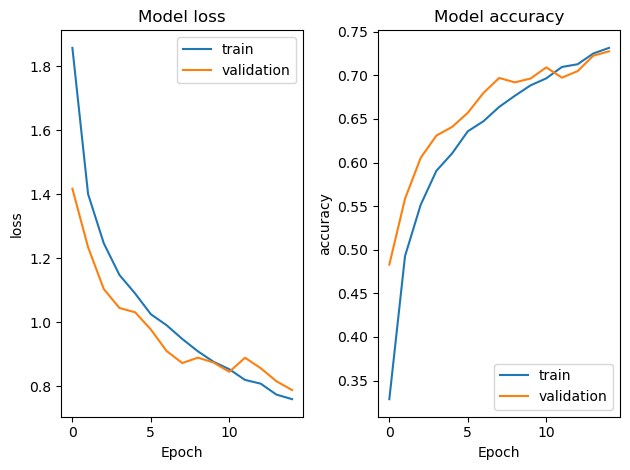

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(model_history.history['loss'])
ax1.plot(model_history.history['val_loss'])
ax1.set_title("Model loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend(['train','validation'], loc = 'upper right')


ax2.plot(model_history.history['accuracy'])
ax2.plot(model_history.history['val_accuracy'])
ax2.set_title("Model accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train','validation'], loc = 'lower right')

plt.tight_layout()
plt.show()

### Q: Was this training with the generator better than training the same model on raw data?

Yes, as we can see in the plots above, the model loss and accuracy for both the validation and training are similar values throughout the entire training process, which is a clear indication that the overtraining issue which plagued the models trained on the raw data has been overcome. 

Additionally, unlike the model trained on the raw datasets, the loss and accuracy of the model for both datasets have not stagnated after 15 epochs. This means that we could likely continue training the model for some more epochs and still see improvements in the preformance of the model without having to worry (too much) about overtraining (This however is still an assumption). 

### Q: What advantages are there to training using an image generator?

By using an image generator, we can "$\textit{artificially}$" boost the number of images we have in out dataset, hence mitigating overtraining of a model.

The word $\textit{artificially}$ referes to te fact that while images that have had transformations applied to them by the generator are different in the eyes of the model to their "parent" image (as the python interpreter will read a different sequence of 1's and 0's compared to the "parent" image), the generated images are still ultimately a subset of their parent image and will contain very similar features which the model will learn.

### Q: What disadvantages are there to using an image generator when training?


Applying transformations to the raw datasets may alter the images to such a point that they are no longer a correct representation of the data class it is meant to represent.

The classic example is rotating images in the MNIST dataset by 180 degrees. By doing this, images that are a member of the class "6" will now look very similar to members of the class "9". As a result, there will be a discrepency between what the lable of the image says it is and what the image looks like. In this example, it would result in the model not being able to correctly classifiy images in the class "6" or "9".

Another example of this specifically for the CIFAR10 is by applying a random zoom/crop to the image. There may be a case where we transform an image in such a way that we crop out the subject of the image and the generated image only contains the background (see the figure below). This would result in the model not reciving appropiate images for each label, which could result in reduced accuracy and possible model artificial hallucination (This would be an extreme example).

The way of mitigatitng this would be to manually inspect that the variables used to define the range of the transformations are resonable and that they do not alter the nature of the classes which each image is meant to represent. This, however, was not done in this example and as a result we have no idea how the datasets created by the image generator actually look like.

Text(0.5, 0.98, 'Example of cropping issue w/ image generators\n\nlabel: ship')

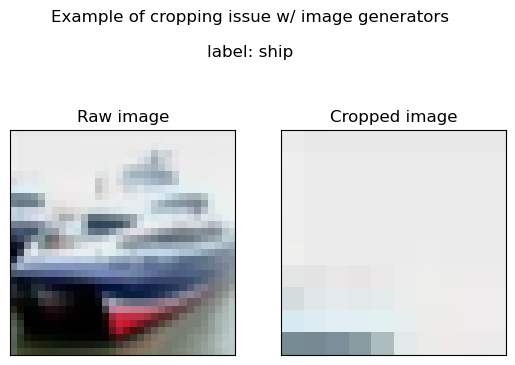

In [57]:
""" 
Example of cropping issue with image generators 
"""

idx = 1
image = X_test[idx]
cropped_image = image[:10, :10]
label = class_names[tf.argmax(y_test[idx])]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(image,)
ax1.set_title("Raw image")
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(cropped_image,)
ax2.set_title("Cropped image")
ax2.set_xticks([])
ax2.set_yticks([])

fig.suptitle(f"Example of cropping issue w/ image generators\n\nlabel: {label}")

# VAE example with mnist dataset
---

This section goes over what is required to build a full VAE model to train over the mnist dataset.

This is an example of performing an un-supervised training on a dataset.

### Data preprocessing and cleaning:
---

As per the last workshop, load the mnist dataset and normalize the data.

In [58]:
# input image dimensions
img_rows, img_cols = (28, 28) 

# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 100
minimum_pixel_value = X_train.min().astype("float32")
maximum_pixel_value = X_train.max().astype("float32")

### Normalize dataset
---
As per last week we want to normalize our dataset for training.

In [59]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Normalize the training and testing datasets-
X_train /= maximum_pixel_value
X_test /= maximum_pixel_value

In [60]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Define Autoencoder using _Functional API_ & _Convolutional_ layers
---

Instead of using the sequential API for tensorflow, we now want to use the functional API:
```
eg:

before we had:

model = Sequential()
model.add(SomeLayer)
model.add(SomeLayer2)
...
model.add(Activation('softmax'))


this now becomes:

input = Input()
x=SomeLayer()(input)
x=SomeLayer2()(x)
...
model=Activation('softmax')(x)
```

Using this API you now need to finish the encoder and deoder model descriptions.


In the encoder, ensure that every Conv2D layer is followed by a `gelu` activator.

In the decoder ensure that the Conv2DTranspose layer uses (3, 3) kernels with 64, 64, 32 and 1 filters in total for each sequential layer.

### Define our latent space
---

We are going to chose to use a latent space of 3 dimensions.
The numer and size of the dimensions depends on the trade-off between the compression and size of the model and accuracy of the final output from the decoder.

In [61]:
# Specify latent space dimensions-
latent_space_dim = 3

The last conv layer is flattened and connected to a Dense layer of size 2, which represents our 2-D latent space.

In [62]:
# Define encoder-

def get_encoder(encoder_output_dim):
    encoder_input = Input(shape = (28,28,1))

    x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(encoder_input)
    x = gelu(x)

    x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same')(x)
    x = gelu(x)

    x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = gelu(x)

    x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
    x = gelu(x)

    x = Flatten()(x)

    x = Dense(units = encoder_output_dim)(x)
    encoder_output = x

    encoder_model = Model(encoder_input, encoder_output)

    return encoder_model, encoder_input, encoder_output


In [63]:
# Sanity check-
encoder_model, encoder_input, encoder_output = get_encoder(latent_space_dim)
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 tf.nn.gelu_7 (TFOpLambda)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 tf.nn.gelu_8 (TFOpLambda)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 tf.nn.gelu_9 (TFOpLambda)   (None, 7, 7, 64)          0   

In [64]:

def get_decoder(decoder_space_dim):
    decoder_input = Input(shape = decoder_space_dim)

    x = Dense(units = 7 * 7 * 64)(decoder_input)
    x = Reshape((7, 7, 64))(x)

    x = Conv2DTranspose(filters=64, kernel_size=3 ,strides = (1, 1), padding = 'same')(x)
    x = gelu(x)

    x = Conv2DTranspose(filters=64, kernel_size=3 ,strides = (2, 2), padding = 'same')(x)
    x = gelu(x)

    x = Conv2DTranspose(filters=32, kernel_size=3, strides = (2, 2), padding = 'same')(x)
    x = gelu(x)

    x = Conv2DTranspose(filters=1, kernel_size=3, strides = (1, 1), padding = 'same')(x)
    x = Activation('sigmoid')(x)

    decoder_output = x

    decoder_model = Model(decoder_input, decoder_output)
    
    return decoder_model, decoder_input, decoder_output


In [65]:
# Sanity check-
decoder_model, decoder_input, decoder_output = get_decoder(latent_space_dim)
decoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_15 (Dense)            (None, 3136)              12544     
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 7, 7, 64)         36928     
 ranspose)                                                       
                                                                 
 tf.nn.gelu_11 (TFOpLambda)  (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                 

## Joining the Encoder to the Decoder
To train the encoder and decoder simultaneously, we need to define a model that will represent the flow of an image through the encoder and back out through the decoder.


In [66]:
# The complete autoencoder-

# The input to the autoencoder is the same as the input to the encoder.
vae_model_input = encoder_input

# The output from the autoencoder is the output from the encoder passed through
# the decoder.
vae_model_output = decoder_model(encoder_output)

# The Keras model that defines the full autoencoder—a model that takes an image,
# and passes it through the encoder and back out through the decoder to generate
# a reconstruction of the original image.
vae_model = Model(vae_model_input, vae_model_output)

In [67]:
# Final sanity check-
vae_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 tf.nn.gelu_7 (TFOpLambda)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 tf.nn.gelu_8 (TFOpLambda)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 tf.nn.gelu_9 (TFOpLambda)   (None, 7, 7, 64)          0   

## Now, make a prediction using the vae_model to see what the output looks like

In [68]:
# Sanity check-
vae_model(X_train[:1, :]).shape

TensorShape([1, 28, 28, 1])

### Q: What is the output shape of the VAE model? Where do the dimension sizes come from?

The output of the VAE should have the same dimentionality as the input. This is due to the fact that we are using the VAE as a generative model which is capable of generating images which are similar to those in the MNIST model.

This is further suported by the fact that in the encoding and decoding sections of the VAE will downsample and upsample the image by the same amount respectivly. This would result in the dimentionality of the image being unchanged.

As a result, as we are using the MNIST dataset as an input with a dimentionality of (CHANNEL = 1, HIGHT = 28, WIDTH = 28), the dimentionallity of the output of the VAE will have be the same.

## Predicting using our Encoder
---
Like when we used the predict function with the DNN model using the Sequential API, we can now make 'predictions' using our encoder of the distribution of datapoints in our un-trained latent space.

In [69]:
# Get encoded latent space representation for train images-
encoded_X_train = encoder_model(X_train[:10000])
encoded_X_train = encoded_X_train.numpy()
print("encoded_X_train.shape: {}".format(encoded_X_train.shape))

encoded_X_train.shape: (10000, 3)


## $\textbf{NOT FINISHED. CHECK WITH OTHERS}$

### Q: Projecting the latent space in 2D
---

Project the values in the latent space corresponding to the first 10,000 of the points in the training dataset.

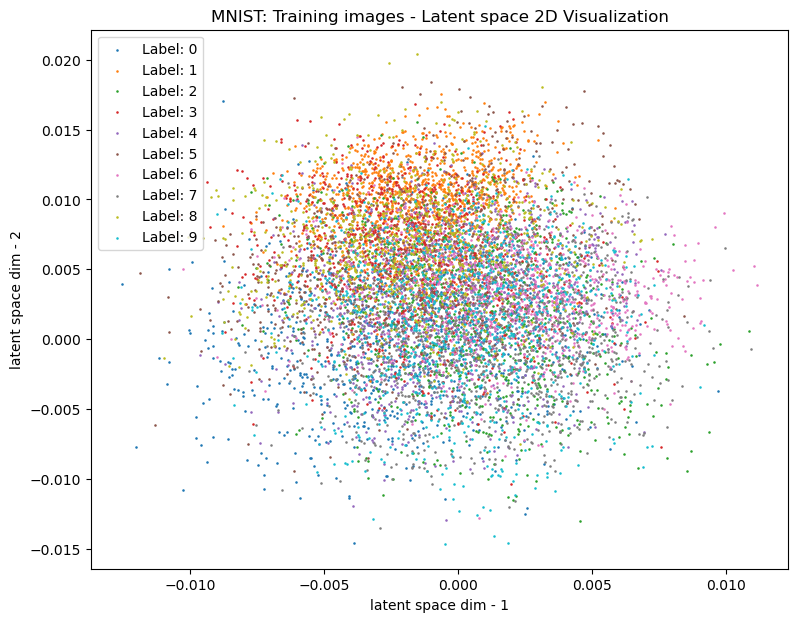

In [70]:
# Visualize latent space of training images-
plt.figure(figsize = (9, 7))
y_labels=np.argmax(y_train[:10000], axis = 1)

datapoints_x = []
datapoints_y = []

for i in range(10):
    datapoints_x = []
    datapoints_y = []
    mask = y_labels == i
    for latent_point in encoded_X_train[mask]:
        
        projected_latent_point = latent_point[:2]
        datapoints_x.append(projected_latent_point[0])
        datapoints_y.append(projected_latent_point[1])
    plt.scatter(datapoints_x, datapoints_y, s=0.7, label=f"Label: {i}")
plt.xlabel("latent space dim - 1")
plt.ylabel("latent space dim - 2")
plt.legend()
plt.title("MNIST: Training images - Latent space 2D Visualization")
plt.show()

### Custom Model features

We will be using a custom loss function to give a spread distribution in our latent space.

We also want to make use of an early_stopping funtion to make sure our model doesn't significatly over-train.

In the case of a VAE the early_stopping function is easier to encode. It may be worth considering **why?**

In [71]:
def RMSE_loss(y_true, y_pred):
    # RMSE loss function.
    return K.mean(K.square(y_true - y_pred), axis = [1, 2, 3])

# Compile defined autoencoder model-
vae_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003), loss = RMSE_loss, metrics=['accuracy'])

# Define early stopping criterion-
early_stopping = EarlyStopping(monitor = 'loss', min_delta = 0.0001, patience = 3, restore_best_weights = True)

## Training our VAE model
---

As before, now we want to train our VAE model.

However, this is an un-supervised training as we will **not** be passing the labels of our dataset to the model and the intention is not to categorize our data, but to construct a decoder which can build images from our dataset based on their latent-space encoding.

In [72]:
# Train autoencoder-
vae_training_hist = vae_model.fit(x = X_train, y = X_train,
    batch_size = batch_size, shuffle = True, validation_data=(X_test, X_test), verbose=2, epochs = num_epochs, callbacks = [early_stopping, ])

Epoch 1/100


938/938 - 31s - loss: 0.0610 - accuracy: 0.7971 - val_loss: 0.0433 - val_accuracy: 0.7993 - 31s/epoch - 33ms/step
Epoch 2/100
938/938 - 31s - loss: 0.0405 - accuracy: 0.8008 - val_loss: 0.0382 - val_accuracy: 0.8007 - 31s/epoch - 33ms/step
Epoch 3/100
938/938 - 29s - loss: 0.0372 - accuracy: 0.8016 - val_loss: 0.0363 - val_accuracy: 0.8012 - 29s/epoch - 31ms/step
Epoch 4/100
938/938 - 31s - loss: 0.0357 - accuracy: 0.8022 - val_loss: 0.0352 - val_accuracy: 0.8020 - 31s/epoch - 33ms/step
Epoch 5/100
938/938 - 30s - loss: 0.0347 - accuracy: 0.8026 - val_loss: 0.0348 - val_accuracy: 0.8012 - 30s/epoch - 33ms/step
Epoch 6/100
938/938 - 31s - loss: 0.0341 - accuracy: 0.8029 - val_loss: 0.0339 - val_accuracy: 0.8010 - 31s/epoch - 33ms/step
Epoch 7/100
938/938 - 31s - loss: 0.0335 - accuracy: 0.8032 - val_loss: 0.0334 - val_accuracy: 0.8031 - 31s/epoch - 33ms/step
Epoch 8/100
938/938 - 31s - loss: 0.0331 - accuracy: 0.8034 - val_loss: 0.0331 - val_accuracy: 0.8029 - 31s/epoch - 33ms/step
Epoc

### Examining the training output
---

Here again we want to look at the loss from the fit function

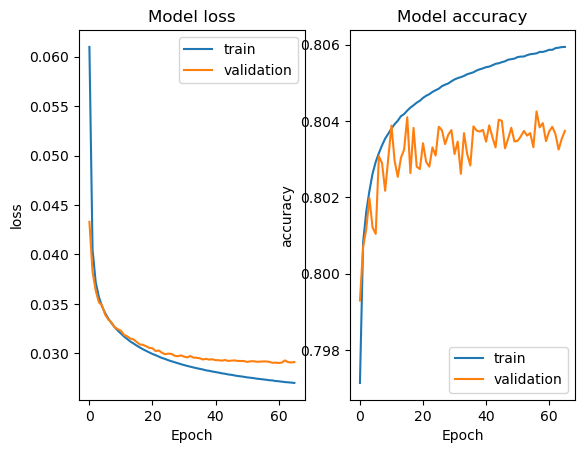

In [73]:
# Visualize autoencoder training-


fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(vae_training_hist.history['loss'])
ax1.plot(vae_training_hist.history['val_loss'])
ax1.set_title("Model loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend(['train','validation'], loc = 'upper right')


ax2.plot(vae_training_hist.history['accuracy'])
ax2.plot(vae_training_hist.history['val_accuracy'])
ax2.set_title("Model accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train','validation'], loc = 'lower right')

## Analysis of _trained_ Autoencoder:
---

Again we can now make predictions using our encoder of our VAE.

In [74]:
# Get encoded latent space representation for train images-
encoded_X_train = encoder_model(X_train[:10000])
encoded_X_train = encoded_X_train.numpy()
print(f"encoded_X_train.shape: {encoded_X_train.shape}")

encoded_X_train.shape: (10000, 3)


In [75]:
# Get encoded latent space representations for test images-
encoded_X_test = encoder_model(X_test)
encoded_X_test = encoded_X_test.numpy()
print(f"encoded_X_test.shape: {encoded_X_test.shape}")

encoded_X_test.shape: (10000, 3)


### Q: Plot the distribution of images in 2D of our latent space

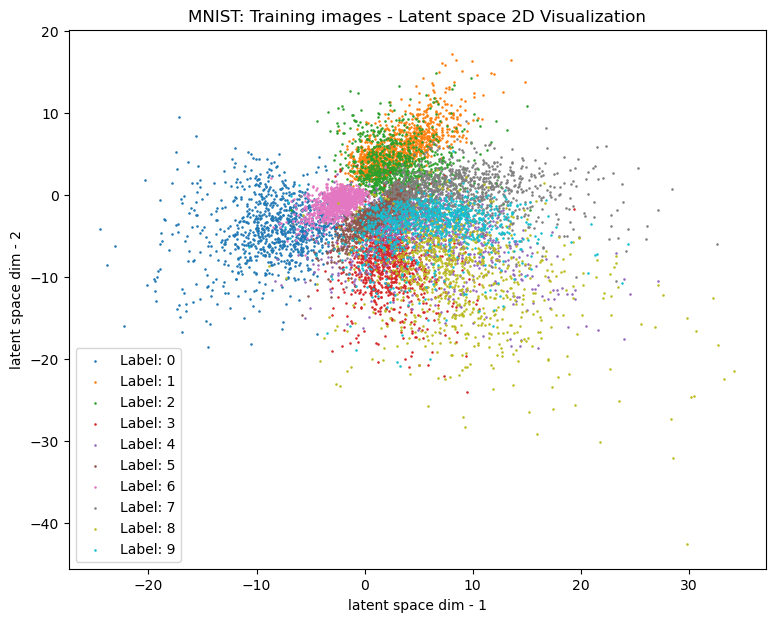

In [76]:
# # Visualize latent space of training images-

plt.figure(figsize = (9, 7))
y_labels=np.argmax(y_train[:10000], axis = 1)

datapoints_x = []
datapoints_y = []

for i in range(10):
    datapoints_x = []
    datapoints_y = []
    mask = y_labels == i
    for latent_point in encoded_X_train[mask]:
        
        projected_latent_point = latent_point[:2]
        datapoints_x.append(projected_latent_point[0])
        datapoints_y.append(projected_latent_point[1])
    plt.scatter(datapoints_x, datapoints_y, s=0.7, label=f"Label: {i}")
plt.xlabel("latent space dim - 1")
plt.ylabel("latent space dim - 2")
plt.legend()
plt.title("MNIST: Training images - Latent space 2D Visualization")
plt.show()

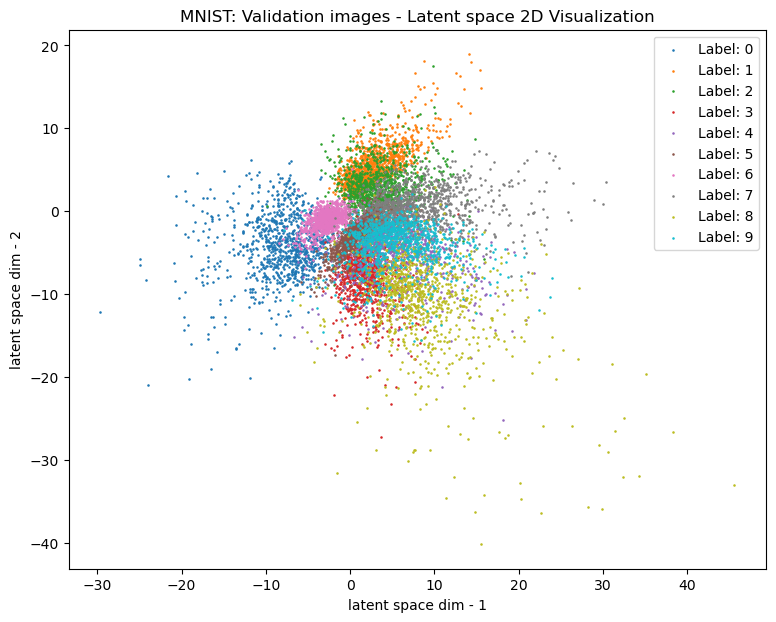

In [77]:
# Visualize latent space of validation images-

plt.figure(figsize = (9, 7))
y_labels=np.argmax(y_test[:10000], axis = 1)

datapoints_x = []
datapoints_y = []

for i in range(10):
    datapoints_x = []
    datapoints_y = []
    mask = y_labels == i
    for latent_point in encoded_X_test[mask]:
        
        projected_latent_point = latent_point[:2]
        datapoints_x.append(projected_latent_point[0])
        datapoints_y.append(projected_latent_point[1])
    plt.scatter(datapoints_x, datapoints_y, s=0.7, label=f"Label: {i}")
plt.xlabel("latent space dim - 1")
plt.ylabel("latent space dim - 2")
plt.legend()
plt.title("MNIST: Validation images - Latent space 2D Visualization")
plt.show()

## Visualize Actual vs. Recreated MNIST Images

### Q: Using trained autoencoder show 5 're-generated' images from our VAE model and compare this to their original 

In [78]:
mnist_entries, mnist_hight, mnist_width, mnist_channel = X_train.shape
print(X_train.shape)

(60000, 28, 28, 1)


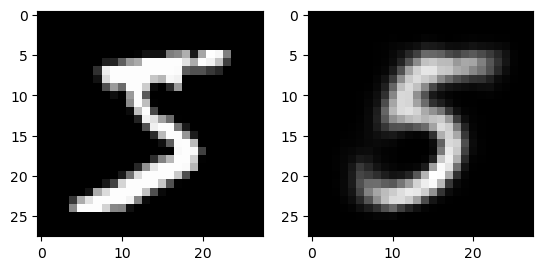

In [79]:
recreated_image = vae_model(X_train[:1, :])
recreated_image = recreated_image.numpy().reshape(28, 28)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[:1, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

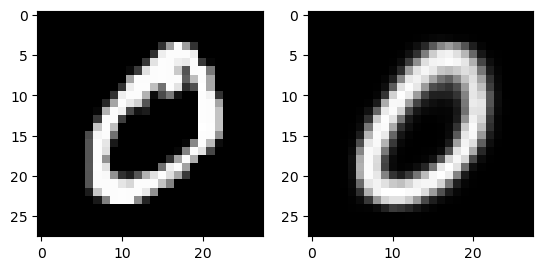

In [80]:
original_image = X_train[1:2, :]
recreated_image = vae_model(original_image).numpy().reshape(28,28)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(original_image.reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

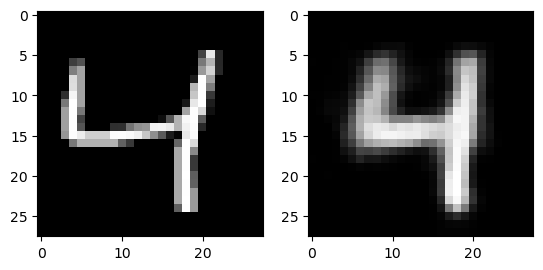

In [81]:
original_image = X_train[2:3, :]
recreated_image = vae_model(original_image).numpy().reshape(28,28)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(original_image.reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

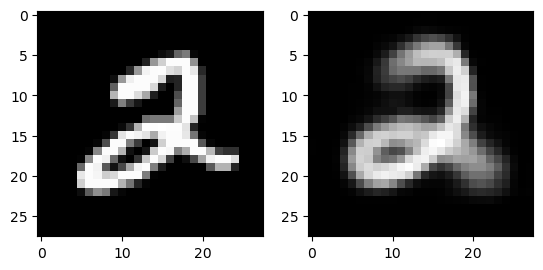

In [82]:
original_image = X_train[5:6, :]
recreated_image = vae_model(original_image).numpy().reshape(28,28)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(original_image.reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

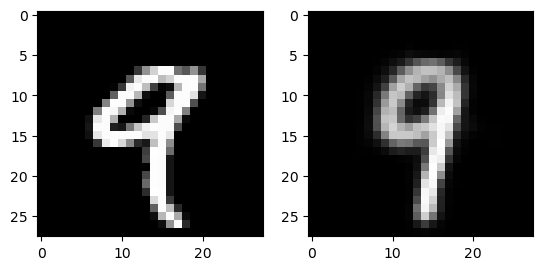

In [83]:
original_image = X_train[4:5, :]
recreated_image = vae_model(original_image).numpy().reshape(28,28)
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(original_image.reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

# Anomaly detection
---

We have introduced auto-encoders as a form of unsupervised learning, since we are not using the image labels during training. This means that auto-encoders are not ideal for image classification (at least not since we actually _have_ the labels), but they can be used for something else: anomaly detection. This is the task of identifying examples that the model considers "anomalous" with respect to the dataset used during training. 

First, we'll load in some "anomalous" data:

In [84]:
faces = fetch_olivetti_faces(shuffle=True)['images']
faces = faces[:,4:-4:2,4:-4:2,np.newaxis]

### Inspect the face images and the auto-encoder result

* How many samples does the "outlier" dataset (_i.e._ `faces`) contain?
* What is the shape of the images and what is the range of pixel intensities? Does this conform with the preprocessed MNIST images?
* Display the first few face images.
* Get the output/prediction of the auto-encoder from the previous section when applied to all of the faces.
* Show the auto-encoded versions of the same faces you showed above. Discuss the results.

The number of outlier entries is 400

The pixel intensity range for the faces dataset is [0.020661156624555588,0.9710744023323059]
The pixel intensity range for the mnist dataset is [0.0,1.0]

The image dimentions of the faces are (1, 28, 28) where (channel, hight, width)
The image dimentions of the MNIST dataset are (1, 28, 28) where (channel, hight, width)

The two datasets constain the same dimentionality and pixel ranges
(3,)


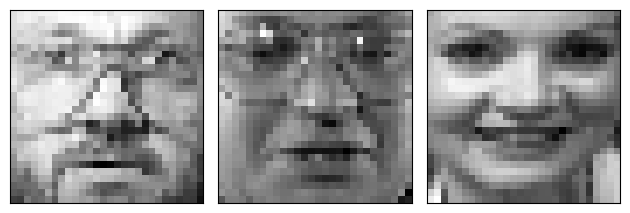

In [85]:
faces_entries, faces_hight, faces_width, faces_channel = faces.shape
faces_pixel_min, faces_pixel_max = faces.min(), faces.max()
mnist_pixel_min, mnist_pixel_max = X_train.min(), X_train.max()

print(f"The number of outlier entries is {faces_entries}\n")
print(f"The pixel intensity range for the faces dataset is [{faces_pixel_min},{faces_pixel_max}]")
print(f"The pixel intensity range for the mnist dataset is [{mnist_pixel_min},{mnist_pixel_max}]\n")
print(f"The image dimentions of the faces are ({faces_channel}, {faces_hight}, {faces_width}) where (channel, hight, width)")
print(f"The image dimentions of the MNIST dataset are ({mnist_channel}, {mnist_hight}, {mnist_width}) where (channel, hight, width)\n")
print("The two datasets constain the same dimentionality and pixel ranges")

# Display first 3 images

fig, axes = plt.subplots(1,3)
print(axes.shape)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(faces[idx], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()


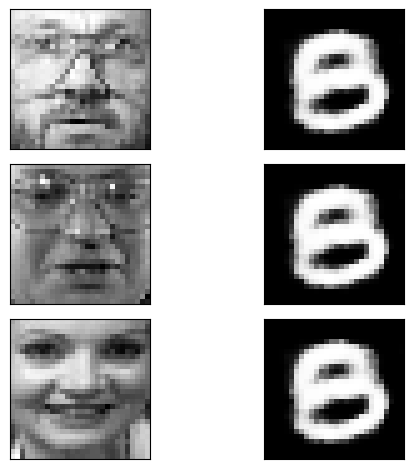

In [86]:
# Pass a face image through the VAE and plot the input and output

fig, axes = plt.subplots(3, 2)

for idx, rowAx in enumerate(axes):
    original_image = faces[idx:idx+1, :]
    recreated_image = vae_model(original_image).numpy().reshape(28,28)
    rowAx[0].imshow(np.squeeze(original_image, axis=0), cmap="gray")
    rowAx[1].imshow(recreated_image, cmap="gray")
    for ax in rowAx:
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

_Indicative answers:_
    
* The face images have the same shape and pixel intensity range as the preprocessed MNIST images, so they are valid inputs to the auto-encoder.
* We can see that the auto-encoder transformed faces are _very_ unlike the input images. This is because the auto-encoder was trained to learn an efficient representation of hand-written digits which is not necessarily an efficient representation for other image domains, _e.g._ faces. This examples shows that this is clearly the case. From the point of view of the auto-encoder, images of faces are _anomalies_ in that they are fundamentally unlike the images on which it was trained, and therefore we shouldn't expect it to do a good job in encoding them.

### Perform anomaly detection
Imagine now that we had a dataset comprised of mostly MNIST images, but also a small subset of anomalies or "outliers"; here, in the form of black-and-white images of facses, with the same shape as the MNIST images.

In [87]:
# Combined MNIST images and "outliers" in a mixed dataset
mixed = np.vstack((X_test, faces))

# Shuffle the mixed dataset so the "outliers" are randomly distributed
indices = np.random.permutation(mixed.shape[0])
mixed   = mixed[indices]

In [88]:
def binary_crossentropy (img_in, img_out):
    assert img_in.shape == img_out.shape
    eps = np.finfo(float).eps
    img_out = np.clip(img_out, eps, 1. - eps)
    return - (img_in * np.log(img_out) + (1 - img_in) * np.log(1 - img_out))

### Q: Anomaly Detection
---
* Define a new method called `difference` which takes as input two arrays of images (`img_in` and `img_out`; similar to the `binary_crossentropy`); computes the **average BCE value for each image,** or row; and returns a vector of these difference measures.
* For each image, or row, in `mixed`, compute the difference score of the auto-encoded image wrt. the original image. This is a measure of how "inlier"- or "outlier"-like an image is.
* Make a histogram of these scores, and see if you can identify any structure. It might be useful to use a logarithmic x-axis (see `plt.xscale`) along with logarithmic x-axis bins (see `np.logspace`).
* Show the 9 least and the 9 most outlying images, according to this difference score. Discuss the results.

  6/325 [..............................] - ETA: 4s 

325/325 [==============================] - 5s 15ms/step
(10400, 28, 28, 1)
(10400,)


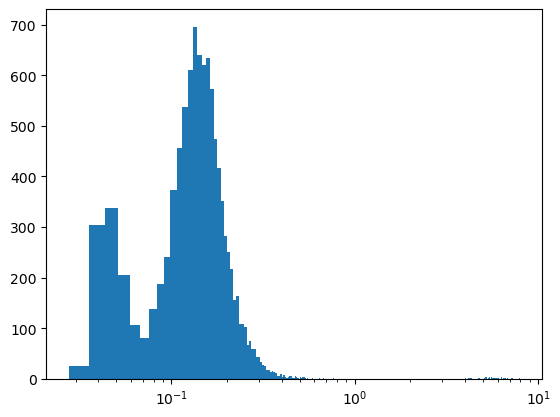

In [110]:
def difference (img_in, img_out):
    ## This method effectively calculates the difference between what is expected and what was prediced
    return binary_crossentropy(img_in, img_out).reshape(10400, -1).mean(axis=1)

## Use the pre-trained mnist model to make predictions on our dataset
p_mixed = vae_model.predict(mixed)
print(p_mixed.shape)
score   = difference(mixed, p_mixed)
print(score.shape)

## Plot the distribution of the magnitude of the bce values for different images

plt.hist(score, bins=1000)
plt.xscale("log")
plt.show()

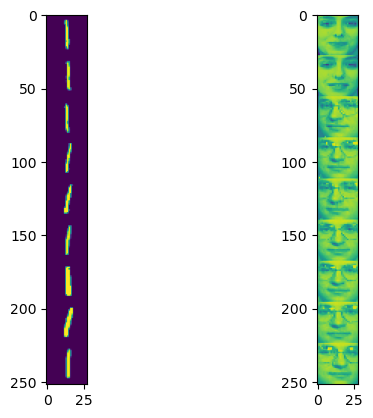

In [105]:
sorted_indices_scores = sorted(zip(np.arange(score.size), score), key=lambda p: p[1])

best_indices  = list(list(zip(*sorted_indices_scores[  :9]))[0])
worst_indices = list(list(zip(*sorted_indices_scores[-9: ]))[0])

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(mixed[best_indices].reshape(9*28,28));
axarr[1].imshow(mixed[worst_indices].reshape(9*28,28));

``` ## FINISH ME ## ```  Discuss what images are at the 2 extremes of the latent-space when reduced to 1D, i.e. which are best reconstructed and maybe why and which images aren't and why that may be the case...

The images with the best score all seem to be images in the class "1". The reasoning due to this may be that as it is the image class in the mnist data with the least non zero pixels, A majority of the image will be similar to the VAE output and hence result in a better (lower) BCE score.

On the other hand, the images with the worst score are anomalous images which are members of the face class. As the VAE was trained to only recreate mnist images, the output of the VAE will differ drastically to the input (As can be noted from a couple plots above where we see the VAE interpret and output imaes resembling an 8 when given images of faces as inputs). This will therefore result in the input and outputs of the VAE having a very high BCE score, which can then be easily distinguished from the other, non-anomalous, images.